In [2]:
from FastSurfer.FastSurferCNN.data_loader.load_neuroimaging_data import load_and_conform_image
import nibabel as nib
from nibabel.processing import conform
import pandas as pd
import matplotlib.pyplot as plt

from PIL import ImageFilter
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torch.nn import CrossEntropyLoss

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm
import os
import random
from pathlib import Path
import joblib

## Data Processing and Loading

In [3]:
df_info = pd.read_csv('data/info.csv')

ORDER_MAP = {'Artiodactyla':0,
 'Carnivora':1,
 'Chiroptera':2,
 'Eulipotyphla':3,
 'Hyracoidea':4,
 'Lagomorpha':5,
 'Marsupialia':6,
 'Perissodactyla':7,
 'Primates':8,
 'Rodentia':9,
 'Scandentia':10,
 'Xenarthra':11}

def normalize_image(img):
    img += abs(img.min())
    img /= img.max()
    return img

def process_raw_image(datadir, f, order):
    if order.empty:
        order = df_info[df_info.Filename.str.fullmatch(f.stem[:f.stem.find('_')])].Order.drop_duplicates()
    if order.size != 1:
        print(f)
        print(order)
        return ''
    
    img = nib.load(f)
    img = img.get_fdata()
    img = np.nan_to_num(img)
    img = normalize_image(img)
    img_arr = trim(img, img != img[0,0,0])
    #print(f'{f} - {img_arr.shape}')
    #img = nib.Nifti1Image(a,affine=img.affine)
    #img = conform(img, out_shape=(256, 256, 256), ).get_fdata()
    
    #trimmed = trim(img, img != img[0,0,0])
    #print(f'{trimmed.shape}')
    
    joblib.dump([img,order], datadir + 'Processed/' + f.stem + '.joblib')
    return f'{f.stem}.joblib,{ORDER_MAP[order.values[0]]}\n'

def process_raw_images(inputdir='MRI', datadir='data/', order=pd.Series(dtype=str)):
    annotations = 'filename,order\n'
    for f in tqdm((Path(datadir)/inputdir).iterdir()):
        annotations += process_raw_image(datadir, f, order)
    with open(Path(datadir)/'labels.csv', 'w') as f:
        f.write(annotations)
        
def load_processed(datadir='data/'):
    train_loader = []
    for f in (Path(datadir)/'Processed').iterdir():
        train_loader.append(joblib.load(f))
    return train_loader

def load_raw(datadir='data/'):
    train_loader = []
    for f in (Path(datadir)/'MRI').iterdir():
        order = df_info[df_info.Filename.str.contains(f.stem[:f.stem.find('_')-1])].Order.drop_duplicates()
        if order.size > 1:
            print(order)
            continue
        img = nib.load(f).get_fdata()
        train_loader.append([img, order])
    return train_loader

def trim(arr, mask):
    bounding_box = tuple(
        slice(np.min(indexes), np.max(indexes) + 1)
        for indexes in np.where(mask))
    return arr[bounding_box]
    

In [126]:
process_raw_images('Resampled')

2it [00:00, 15.63it/s]

data\Resampled\.nii.gz
Series([], Name: Order, dtype: object)


53it [00:06,  8.61it/s]


In [47]:
process_raw_images('Resampled', datadir='f:/Data/OpenNeuro/ds004114-download/', order=pd.Series(['Rodentia']))

751it [01:14, 10.07it/s]


### Train Test split

In [132]:
df_info = pd.read_csv('data/labels.csv')
df_info = df_info.loc[df_info['order'].isin([0,1])]

In [133]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_info, test_size=0.33, random_state=42)

In [134]:
train.to_csv("data/train.csv", index=False)

In [135]:
test.to_csv("data/test.csv", index=False)

In [37]:
img, order = joblib.load("f:/Data/OpenNeuro/ds004215-download/Processed/sub-ON01016_ses-01_acq-CUBE_T2w.nii.joblib")

In [51]:
df_info = pd.read_csv('f:/Data/OpenNeuro/labels.csv')

In [52]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_info, test_size=0.33, random_state=42)

In [54]:
train.to_csv("f:/Data/OpenNeuro//train.csv", index=False)

In [55]:
test.to_csv("f:/Data/OpenNeuro//test.csv", index=False)

In [37]:
img, order = joblib.load("f:/Data/OpenNeuro/ds004215-download/Processed/sub-ON01016_ses-01_acq-CUBE_T2w.nii.joblib")

In [46]:
plt.imshow(img[:,:,121])
plt.colorbar()
plt.show()

IndexError: index 121 is out of bounds for axis 2 with size 121

In [13]:
model = torch.load('yAwareContrastiveLearning/fine_tune_epoch_50.pth')
losses = model['losses']

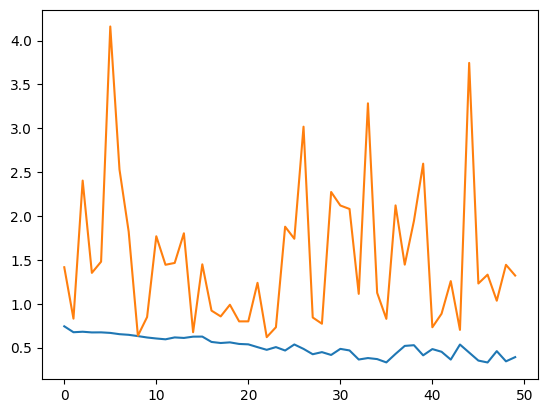

In [18]:
plt.plot(range(len(losses['train'])), losses['train'])
plt.plot(range(len(losses['validation'])), losses['validation'])
plt.show()

## SWaV

In [8]:
def train(train_loader, model, optimizer, epoch, lr_schedule, queue):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train()
    use_the_queue = False

    end = time.time()
    for it, inputs in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        # update learning rate
        iteration = epoch * len(train_loader) + it
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr_schedule[iteration]

        # normalize the prototypes
        with torch.no_grad():
            w = model.module.prototypes.weight.data.clone()
            w = nn.functional.normalize(w, dim=1, p=2)
            model.module.prototypes.weight.copy_(w)

        # ============ multi-res forward passes ... ============
        embedding, output = model(inputs)
        embedding = embedding.detach()
        bs = inputs[0].size(0)

        # ============ swav loss ... ============
        loss = 0
        for i, crop_id in enumerate(args.crops_for_assign):
            with torch.no_grad():
                out = output[bs * crop_id: bs * (crop_id + 1)].detach()

                # time to use the queue
                if queue is not None:
                    if use_the_queue or not torch.all(queue[i, -1, :] == 0):
                        use_the_queue = True
                        out = torch.cat((torch.mm(
                            queue[i],
                            model.module.prototypes.weight.t()
                        ), out))
                    # fill the queue
                    queue[i, bs:] = queue[i, :-bs].clone()
                    queue[i, :bs] = embedding[crop_id * bs: (crop_id + 1) * bs]

                # get assignments
                q = distributed_sinkhorn(out)[-bs:]

            # cluster assignment prediction
            subloss = 0
            for v in np.delete(np.arange(np.sum(args.nmb_crops)), crop_id):
                x = output[bs * v: bs * (v + 1)] / args.temperature
                subloss -= torch.mean(torch.sum(q * F.log_softmax(x, dim=1), dim=1))
            loss += subloss / (np.sum(args.nmb_crops) - 1)
        loss /= len(args.crops_for_assign)

        # ============ backward and optim step ... ============
        optimizer.zero_grad()
        if args.use_fp16:
            with apex.amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        # cancel gradients for the prototypes
        if iteration < args.freeze_prototypes_niters:
            for name, p in model.named_parameters():
                if "prototypes" in name:
                    p.grad = None
        optimizer.step()

        # ============ misc ... ============
        losses.update(loss.item(), inputs[0].size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        if args.rank ==0 and it % 50 == 0:
            logger.info(
                "Epoch: [{0}][{1}]\t"
                "Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                "Data {data_time.val:.3f} ({data_time.avg:.3f})\t"
                "Loss {loss.val:.4f} ({loss.avg:.4f})\t"
                "Lr: {lr:.4f}".format(
                    epoch,
                    it,
                    batch_time=batch_time,
                    data_time=data_time,
                    loss=losses,
                    lr=optimizer.optim.param_groups[0]["lr"],
                )
            )
    return (epoch, losses.avg), queue

@torch.no_grad()
def distributed_sinkhorn(out):
    Q = torch.exp(out / args.epsilon).t() # Q is K-by-B for consistency with notations from our paper
    B = Q.shape[1] * args.world_size # number of samples to assign
    K = Q.shape[0] # how many prototypes

    # make the matrix sums to 1
    sum_Q = torch.sum(Q)
    dist.all_reduce(sum_Q)
    Q /= sum_Q

    for it in range(args.sinkhorn_iterations):
        # normalize each row: total weight per prototype must be 1/K
        sum_of_rows = torch.sum(Q, dim=1, keepdim=True)
        dist.all_reduce(sum_of_rows)
        Q /= sum_of_rows
        Q /= K

        # normalize each column: total weight per sample must be 1/B
        Q /= torch.sum(Q, dim=0, keepdim=True)
        Q /= B

    Q *= B # the colomns must sum to 1 so that Q is an assignment
    return Q.t()